<a href="https://colab.research.google.com/github/aashish-thapa/Medical-Appointment-No-Shows-Prediction/blob/main/willshowupornot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install pandas numpy scikit-learn matplotlib seaborn lightgbm catboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

try:
    df = pd.read_csv('KaggleV2-May-2016.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'KaggleV2-May-2016.csv' not found. Please upload the dataset to your Colab environment or provide the correct path.")
# Display basic info
print("\nDataset Head:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nMissing Values:")
print(df.isnull().sum())

Dataset loaded successfully!

Dataset Head:
      PatientId  AppointmentID Gender          ScheduledDay  \
0  2.987250e+13        5642903      F  2016-04-29T18:38:08Z   
1  5.589978e+14        5642503      M  2016-04-29T16:08:27Z   
2  4.262962e+12        5642549      F  2016-04-29T16:19:04Z   
3  8.679512e+11        5642828      F  2016-04-29T17:29:31Z   
4  8.841186e+12        5642494      F  2016-04-29T16:07:23Z   

         AppointmentDay  Age      Neighbourhood  Scholarship  Hipertension  \
0  2016-04-29T00:00:00Z   62    JARDIM DA PENHA            0             1   
1  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             0   
2  2016-04-29T00:00:00Z   62      MATA DA PRAIA            0             0   
3  2016-04-29T00:00:00Z    8  PONTAL DE CAMBURI            0             0   
4  2016-04-29T00:00:00Z   56    JARDIM DA PENHA            0             1   

   Diabetes  Alcoholism  Handcap  SMS_received No-show  
0         0           0        0             0     

## Data Preprocessing


Columns after renaming:
Index(['patientid', 'appointmentid', 'gender', 'scheduledday',
       'appointmentday', 'age', 'neighbourhood', 'scholarship', 'hypertension',
       'diabetes', 'alcoholism', 'handicap', 'sms_received', 'no_show'],
      dtype='object')

Data types after datetime conversion:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   scheduledday    110527 non-null  datetime64[ns]
 1   appointmentday  110527 non-null  datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 1.7 MB
None

Number of appointments with negative waiting time days: 38568

New features created and target variable encoded.
      patientid  appointmentid gender        scheduledday appointmentday  age  \
0  2.987250e+13        5642903      F 2016-04-29 18:38:08     2016-04-29   62   
1  5.589978e+14        5642503      M 2016-04-29

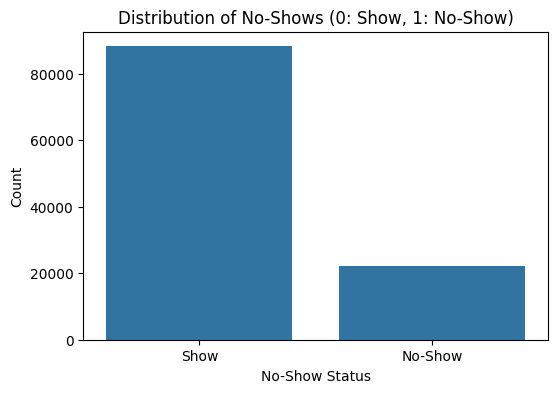


No-Show Distribution:
no_show_numeric
0    88208
1    22319
Name: count, dtype: int64
Percentage of No-Shows: 20.19%
Percentage of Shows: 79.81%


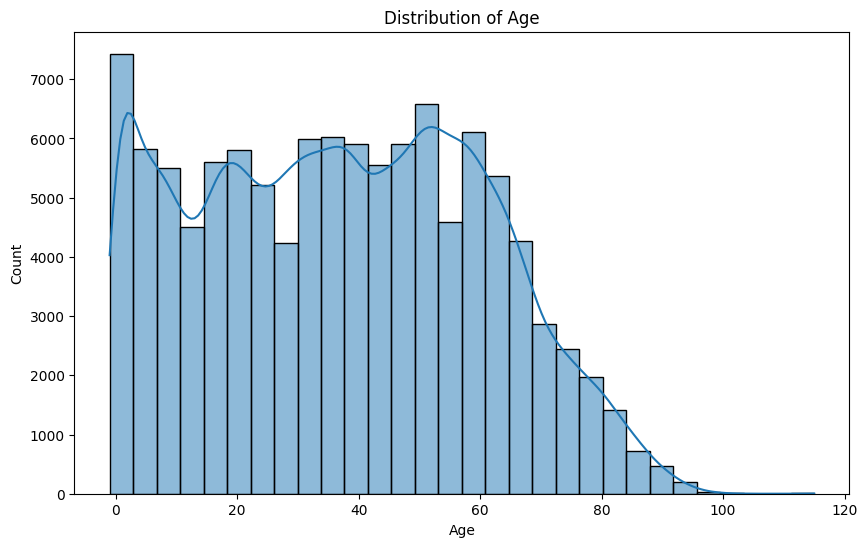

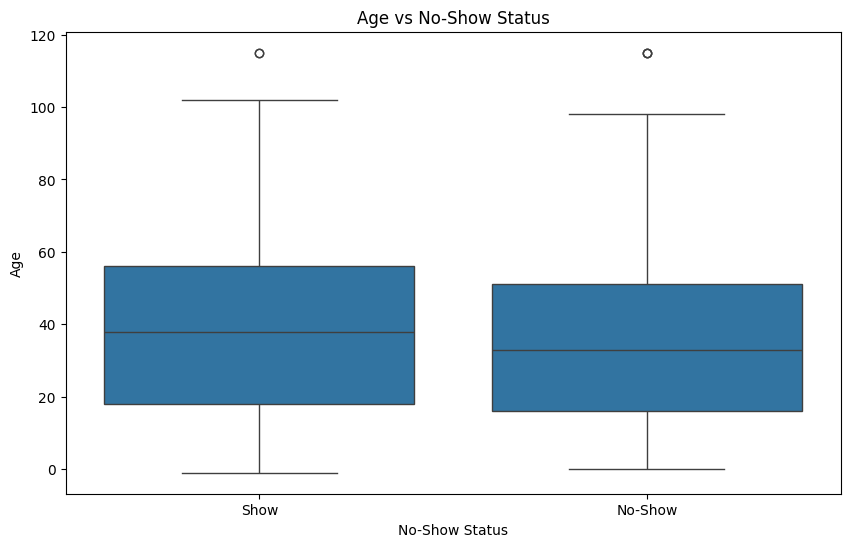

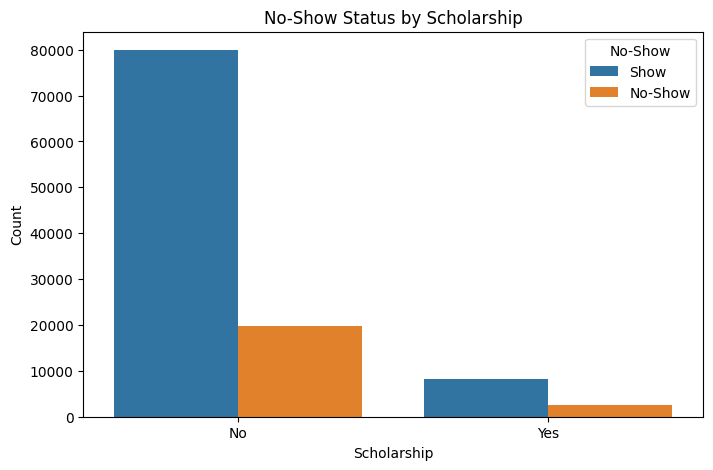


Proportion of No-Shows for Scholarship:
no_show_numeric          0          1
scholarship                          
0                80.192844  19.807156
1                76.263696  23.736304


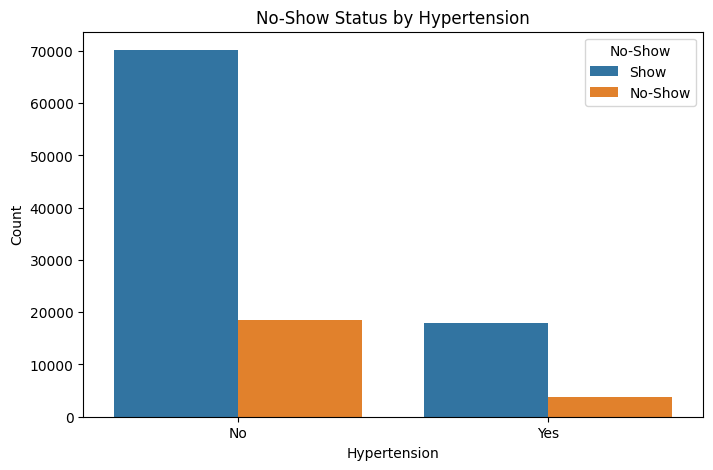


Proportion of No-Shows for Hypertension:
no_show_numeric          0          1
hypertension                         
0                79.096319  20.903681
1                82.698041  17.301959


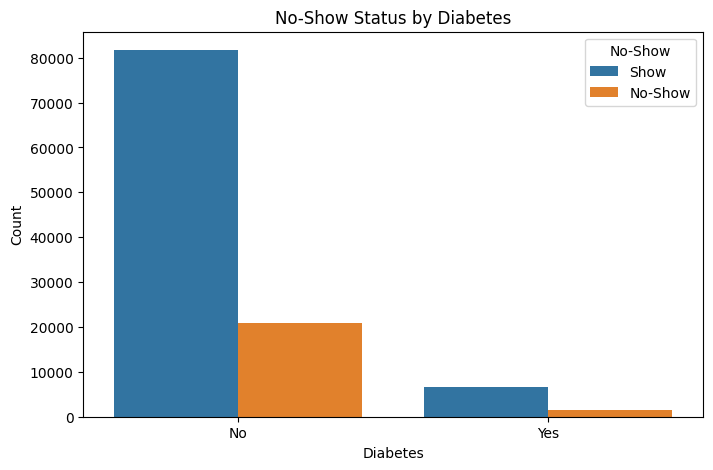


Proportion of No-Shows for Diabetes:
no_show_numeric          0          1
diabetes                             
0                79.637175  20.362825
1                81.996727  18.003273


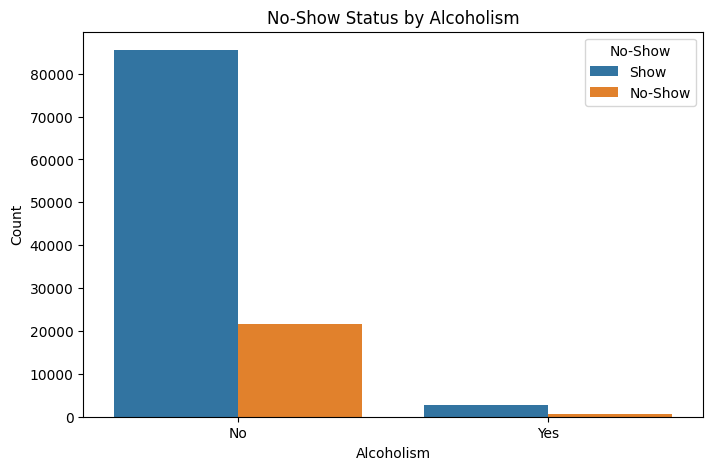


Proportion of No-Shows for Alcoholism:
no_show_numeric          0          1
alcoholism                           
0                79.805351  20.194649
1                79.851190  20.148810


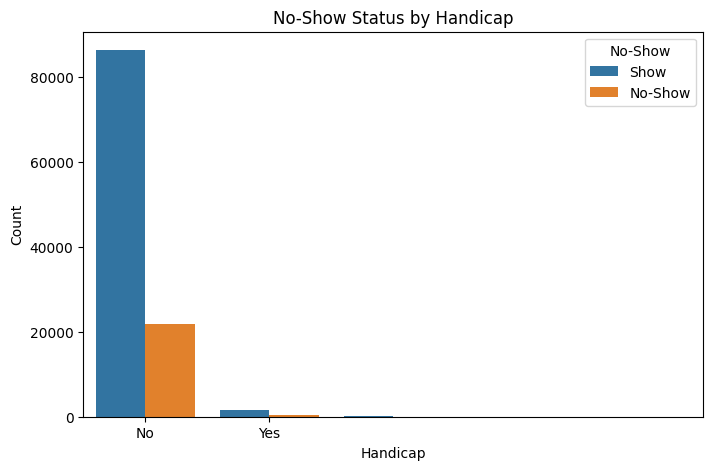


Proportion of No-Shows for Handicap:
no_show_numeric          0          1
handicap                             
0                79.764697  20.235303
1                82.076396  17.923604
2                79.781421  20.218579
3                76.923077  23.076923
4                66.666667  33.333333


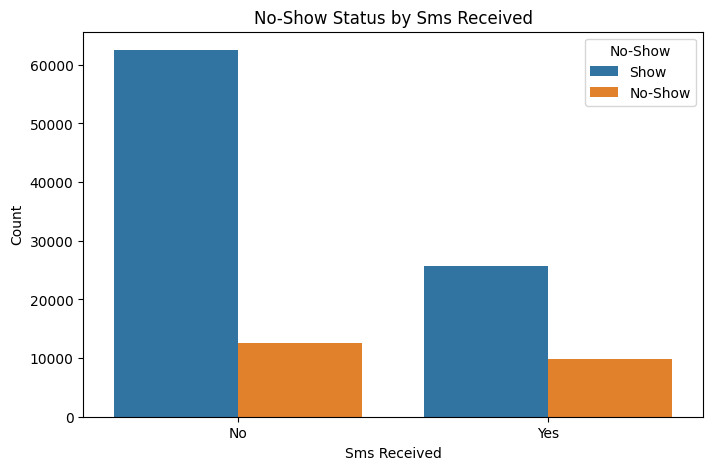


Proportion of No-Shows for Sms Received:
no_show_numeric          0          1
sms_received                         
0                83.296689  16.703311
1                72.425455  27.574545


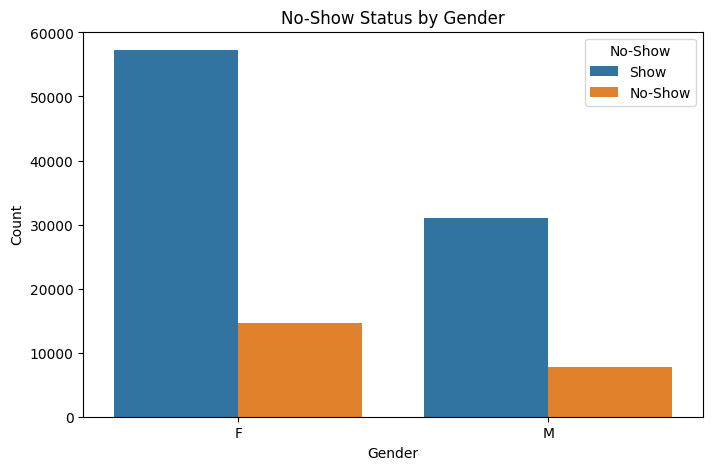


Proportion of No-Shows by Gender:
no_show_numeric          0          1
gender                               
F                79.685412  20.314588
M                80.032052  19.967948

Number of unique neighborhoods: 81

Top 10 Neighbourhoods by No-Shows:
neighbourhood
JARDIM CAMBURI       1465
MARIA ORTIZ          1219
ITARARÉ               923
RESISTÊNCIA           906
CENTRO                703
JESUS DE NAZARETH     696
JARDIM DA PENHA       631
CARATOÍRA             591
TABUAZEIRO            573
BONFIM                550
Name: count, dtype: int64


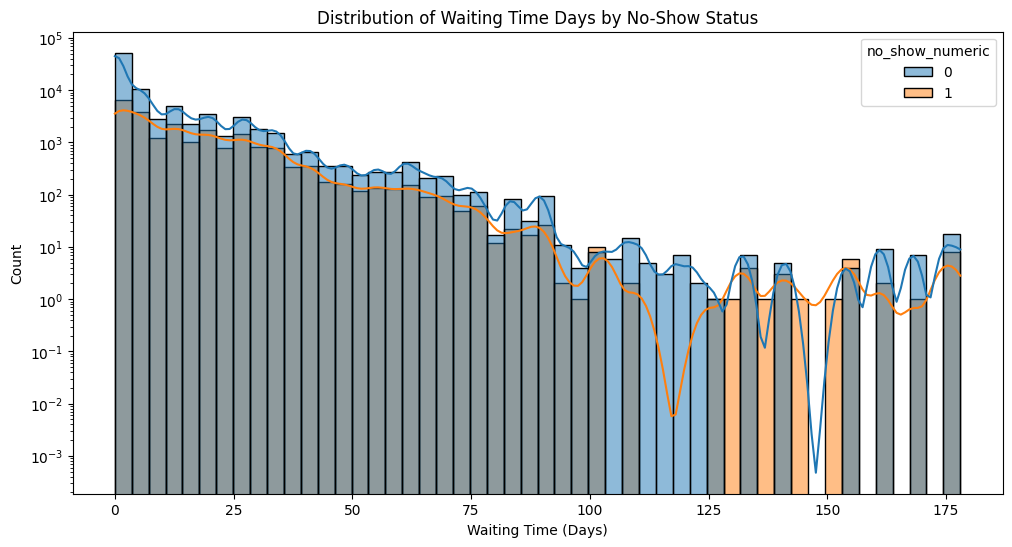

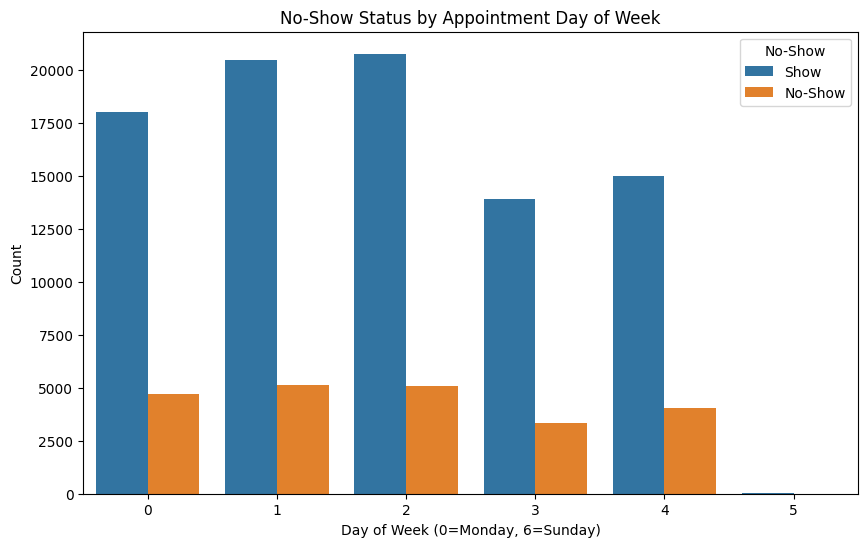


Proportion of No-Shows by Appointment Day of Week:
no_show_numeric                  0          1
day_of_week_appointment                      
0                        79.352851  20.647149
1                        79.906396  20.093604
2                        80.310821  19.689179
3                        80.645909  19.354091
4                        78.773858  21.226142
5                        76.923077  23.076923


In [6]:
df.columns = df.columns.str.replace('-', '_').str.lower()
df = df.rename(columns={'hipertension': 'hypertension', 'handcap': 'handicap'})

print("\nColumns after renaming:")
print(df.columns)

df['scheduledday'] = pd.to_datetime(df['scheduledday'], format='%Y-%m-%dT%H:%M:%SZ')
df['appointmentday'] = pd.to_datetime(df['appointmentday'], format='%Y-%m-%dT%H:%M:%SZ')

print("\nData types after datetime conversion:")
print(df[['scheduledday', 'appointmentday']].info())


df['day_of_week_scheduled'] = df['scheduledday'].dt.dayofweek
df['day_of_week_appointment'] = df['appointmentday'].dt.dayofweek

df['waiting_time_days'] = (df['appointmentday'] - df['scheduledday']).dt.days

print(f"\nNumber of appointments with negative waiting time days: {df[df['waiting_time_days'] < 0].shape[0]}")
df['waiting_time_days'] = df['waiting_time_days'].apply(lambda x: x if x >= 0 else 0)

df['no_show_numeric'] = df['no_show'].apply(lambda x: 1 if x == 'Yes' else 0)

df = df.drop(columns=['no_show'])

print("\nNew features created and target variable encoded.")
print(df.head())

print("\nDescriptive Statistics of Numerical Features:")
print(df.describe())

plt.figure(figsize=(6, 4))
sns.countplot(x='no_show_numeric', data=df)
plt.title('Distribution of No-Shows (0: Show, 1: No-Show)')
plt.xlabel('No-Show Status')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Show', 'No-Show'])
plt.show()

no_show_counts = df['no_show_numeric'].value_counts()
print(f"\nNo-Show Distribution:\n{no_show_counts}")
print(f"Percentage of No-Shows: {no_show_counts[1]/len(df)*100:.2f}%")
print(f"Percentage of Shows: {no_show_counts[0]/len(df)*100:.2f}%")


# Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Age vs No-Show (Boxplot or Violin Plot)
plt.figure(figsize=(10, 6))
sns.boxplot(x='no_show_numeric', y='age', data=df)
plt.title('Age vs No-Show Status')
plt.xlabel('No-Show Status')
plt.ylabel('Age')
plt.xticks(ticks=[0, 1], labels=['Show', 'No-Show'])
plt.show()

# Scholarship, Hypertension, Diabetes, Alcoholism, Handicap, SMS_received
binary_features = ['scholarship', 'hypertension', 'diabetes', 'alcoholism', 'handicap', 'sms_received']

for feature in binary_features:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=feature, hue='no_show_numeric', data=df)
    plt.title(f'No-Show Status by {feature.replace("_", " ").title()}')
    plt.xlabel(feature.replace("_", " ").title())
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
    plt.legend(title='No-Show', labels=['Show', 'No-Show'])
    plt.show()

    pivot_table = df.groupby(feature)['no_show_numeric'].value_counts(normalize=True).unstack()
    print(f"\nProportion of No-Shows for {feature.replace('_', ' ').title()}:\n{pivot_table * 100}")


# Gender vs No-Show
plt.figure(figsize=(8, 5))
sns.countplot(x='gender', hue='no_show_numeric', data=df)
plt.title('No-Show Status by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='No-Show', labels=['Show', 'No-Show'])
plt.show()

gender_pivot = df.groupby('gender')['no_show_numeric'].value_counts(normalize=True).unstack()
print(f"\nProportion of No-Shows by Gender:\n{gender_pivot * 100}")


print(f"\nNumber of unique neighborhoods: {df['neighbourhood'].nunique()}")
top_no_show_neighbourhoods = df[df['no_show_numeric'] == 1]['neighbourhood'].value_counts().head(10)
print("\nTop 10 Neighbourhoods by No-Shows:")
print(top_no_show_neighbourhoods)

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='waiting_time_days', hue='no_show_numeric', bins=50, kde=True)
plt.title('Distribution of Waiting Time Days by No-Show Status')
plt.xlabel('Waiting Time (Days)')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

# Day of week appointment vs No-Show
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week_appointment', hue='no_show_numeric', data=df)
plt.title('No-Show Status by Appointment Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Count')
plt.legend(title='No-Show', labels=['Show', 'No-Show'])
plt.show()

day_of_week_pivot = df.groupby('day_of_week_appointment')['no_show_numeric'].value_counts(normalize=True).unstack()
print(f"\nProportion of No-Shows by Appointment Day of Week:\n{day_of_week_pivot * 100}")

## Train Test Split

In [7]:
initial_rows = df.shape[0]
df = df[df['age'] >= 0]
rows_after_age_filter = df.shape[0]
print(f"Removed {initial_rows - rows_after_age_filter} rows with invalid age (< 0).")

df = df.drop(columns=['patientid', 'appointmentid', 'scheduledday', 'appointmentday'])
print("Dropped 'patientid', 'appointmentid', 'scheduledday', 'appointmentday' columns.")


categorical_features = ['gender', 'neighbourhood', 'day_of_week_scheduled', 'day_of_week_appointment']
numerical_features = ['age', 'waiting_time_days', 'scholarship', 'hypertension', 'diabetes', 'alcoholism', 'handicap', 'sms_received']

X = df.drop('no_show_numeric', axis=1)
y = df['no_show_numeric']

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTraining set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

print("\nPreprocessor (ColumnTransformer) created successfully.")
print("Proceeding to Model Training in the next step.")

Removed 1 rows with invalid age (< 0).
Dropped 'patientid', 'appointmentid', 'scheduledday', 'appointmentday' columns.

Features (X) shape: (110526, 12)
Target (y) shape: (110526,)

Training set shape: X_train=(88420, 12), y_train=(88420,)
Testing set shape: X_test=(22106, 12), y_test=(22106,)

Preprocessor (ColumnTransformer) created successfully.
Proceeding to Model Training in the next step.


## Train and Evaluation


Training Logistic Regression...

--- Logistic Regression Performance ---
Accuracy: 0.6544
Precision (No-Show): 0.3104
Recall (No-Show): 0.5822
F1-Score (No-Show): 0.4049
ROC-AUC: 0.6657

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

        Show       0.86      0.67      0.76     17642
     No-Show       0.31      0.58      0.40      4464

    accuracy                           0.65     22106
   macro avg       0.59      0.63      0.58     22106
weighted avg       0.75      0.65      0.69     22106

Confusion Matrix for Logistic Regression:
[[11867  5775]
 [ 1865  2599]]


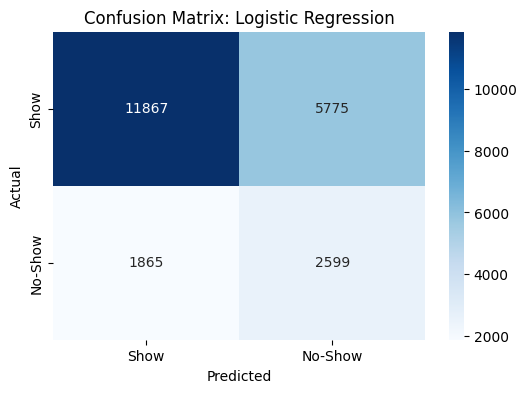


Training Decision Tree...

--- Decision Tree Performance ---
Accuracy: 0.7135
Precision (No-Show): 0.3203
Recall (No-Show): 0.3730
F1-Score (No-Show): 0.3446
ROC-AUC: 0.5880

Classification Report for Decision Tree:
              precision    recall  f1-score   support

        Show       0.83      0.80      0.82     17642
     No-Show       0.32      0.37      0.34      4464

    accuracy                           0.71     22106
   macro avg       0.58      0.59      0.58     22106
weighted avg       0.73      0.71      0.72     22106

Confusion Matrix for Decision Tree:
[[14108  3534]
 [ 2799  1665]]


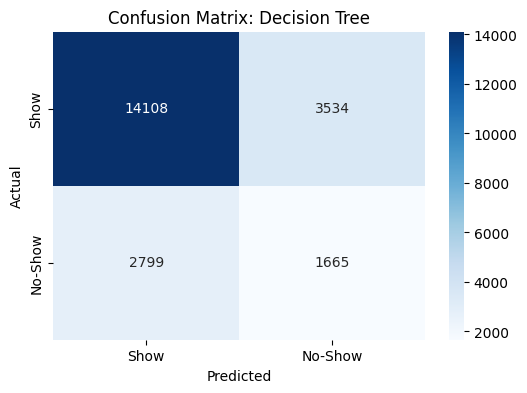


Training Random Forest...

--- Random Forest Performance ---
Accuracy: 0.7695
Precision (No-Show): 0.3741
Recall (No-Show): 0.2103
F1-Score (No-Show): 0.2693
ROC-AUC: 0.7107

Classification Report for Random Forest:
              precision    recall  f1-score   support

        Show       0.82      0.91      0.86     17642
     No-Show       0.37      0.21      0.27      4464

    accuracy                           0.77     22106
   macro avg       0.60      0.56      0.57     22106
weighted avg       0.73      0.77      0.74     22106

Confusion Matrix for Random Forest:
[[16071  1571]
 [ 3525   939]]


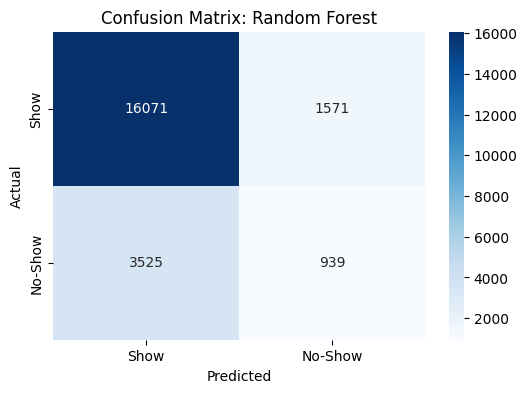


Training Gradient Boosting (LightGBM)...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 17855, number of negative: 70565
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 419
[LightGBM] [Info] Number of data points in the train set: 88420, number of used features: 99
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



--- Gradient Boosting (LightGBM) Performance ---
Accuracy: 0.6039
Precision (No-Show): 0.3129
Recall (No-Show): 0.8044
F1-Score (No-Show): 0.4506
ROC-AUC: 0.7380

Classification Report for Gradient Boosting (LightGBM):
              precision    recall  f1-score   support

        Show       0.92      0.55      0.69     17642
     No-Show       0.31      0.80      0.45      4464

    accuracy                           0.60     22106
   macro avg       0.62      0.68      0.57     22106
weighted avg       0.80      0.60      0.64     22106

Confusion Matrix for Gradient Boosting (LightGBM):
[[9758 7884]
 [ 873 3591]]


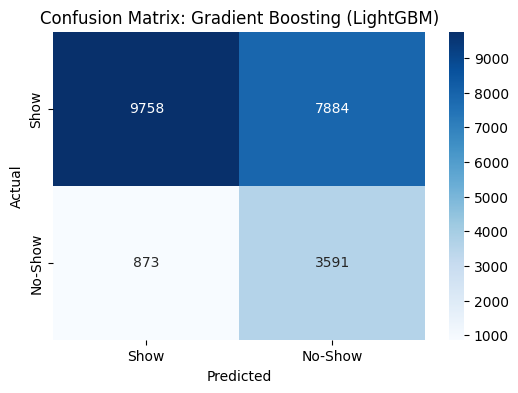


Training Gradient Boosting (CatBoost)...

--- Gradient Boosting (CatBoost) Performance ---
Accuracy: 0.6259
Precision (No-Show): 0.3211
Recall (No-Show): 0.7652
F1-Score (No-Show): 0.4524
ROC-AUC: 0.7436

Classification Report for Gradient Boosting (CatBoost):
              precision    recall  f1-score   support

        Show       0.91      0.59      0.72     17642
     No-Show       0.32      0.77      0.45      4464

    accuracy                           0.63     22106
   macro avg       0.61      0.68      0.58     22106
weighted avg       0.79      0.63      0.66     22106

Confusion Matrix for Gradient Boosting (CatBoost):
[[10421  7221]
 [ 1048  3416]]


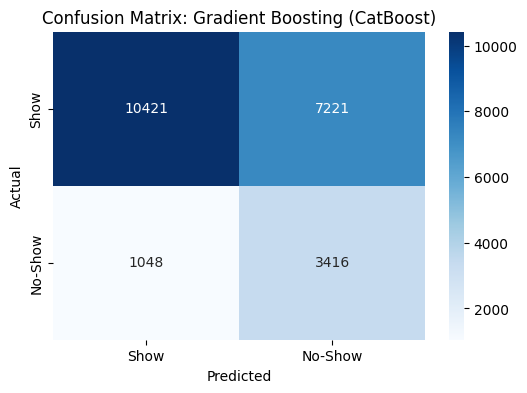

In [8]:
no_show_counts_y_train = y_train.value_counts()
weight_for_no_show_class = no_show_counts_y_train[0] / no_show_counts_y_train[1] # Weight for class 1 (No-show)
weight_for_show_class = no_show_counts_y_train[1] / no_show_counts_y_train[0] # Weight for class 0 (Show)

models = {
    'Logistic Regression': LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting (LightGBM)': LGBMClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting (CatBoost)': CatBoostClassifier(random_state=42, verbose=0,
                                                       class_weights={0: 1/no_show_counts_y_train[0], 1: 1/no_show_counts_y_train[1]})

}

results = {}
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    pipeline.fit(X_train, y_train)
    trained_models[name] = pipeline

    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1] # Probability of the positive class (1: No-show)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    }

    print(f"\n--- {name} Performance ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (No-Show): {precision:.4f}")
    print(f"Recall (No-Show): {recall:.4f}")
    print(f"F1-Score (No-Show): {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    print(f"\nClassification Report for {name}:\n{classification_report(y_test, y_pred, target_names=['Show', 'No-Show'])}")

    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for {name}:\n{cm}")
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Show', 'No-Show'], yticklabels=['Show', 'No-Show'])
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()



## Hyperparameter Tuning

Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best parameters for CatBoost: {'classifier__depth': 6, 'classifier__iterations': 200, 'classifier__l2_leaf_reg': 1, 'classifier__learning_rate': 0.1}
Best F1-score from Grid Search (CatBoost): 0.4499

--- Tuned CatBoost Performance on Test Set ---
Accuracy: 0.6064
Precision (No-Show): 0.3147
Recall (No-Show): 0.8060
F1-Score (No-Show): 0.4527
ROC-AUC: 0.7397

Classification Report for Tuned CatBoost:
              precision    recall  f1-score   support

        Show       0.92      0.56      0.69     17642
     No-Show       0.31      0.81      0.45      4464

    accuracy                           0.61     22106
   macro avg       0.62      0.68      0.57     22106
weighted avg       0.80      0.61      0.64     22106

Confusion Matrix for Tuned CatBoost:
[[9807 7835]
 [ 866 3598]]


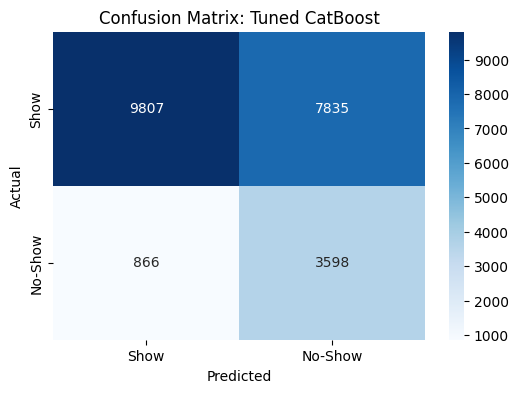

In [9]:
catboost_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                    ('classifier', CatBoostClassifier(random_state=42, verbose=0,
                                                                      class_weights={0: 1/no_show_counts_y_train[0], 1: 1/no_show_counts_y_train[1]}))])

param_grid_catboost = {
    'classifier__iterations': [100, 200],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__depth': [4, 6],
    'classifier__l2_leaf_reg': [1, 3]
}


grid_search_catboost = GridSearchCV(catboost_pipeline, param_grid_catboost,
                                    cv=3, scoring='f1', n_jobs=-1, verbose=2)

grid_search_catboost.fit(X_train, y_train)

print(f"\nBest parameters for CatBoost: {grid_search_catboost.best_params_}")
print(f"Best F1-score from Grid Search (CatBoost): {grid_search_catboost.best_score_:.4f}")

best_catboost_model = grid_search_catboost.best_estimator_
y_pred_tuned_catboost = best_catboost_model.predict(X_test)
y_pred_proba_tuned_catboost = best_catboost_model.predict_proba(X_test)[:, 1]

# Calculate and print metrics for the tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned_catboost)
precision_tuned = precision_score(y_test, y_pred_tuned_catboost, pos_label=1)
recall_tuned = recall_score(y_test, y_pred_tuned_catboost, pos_label=1)
f1_tuned = f1_score(y_test, y_pred_tuned_catboost, pos_label=1)
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned_catboost)

print(f"\n--- Tuned CatBoost Performance on Test Set ---")
print(f"Accuracy: {accuracy_tuned:.4f}")
print(f"Precision (No-Show): {precision_tuned:.4f}")
print(f"Recall (No-Show): {recall_tuned:.4f}")
print(f"F1-Score (No-Show): {f1_tuned:.4f}")
print(f"ROC-AUC: {roc_auc_tuned:.4f}")

print(f"\nClassification Report for Tuned CatBoost:\n{classification_report(y_test, y_pred_tuned_catboost, target_names=['Show', 'No-Show'])}")
cm_tuned = confusion_matrix(y_test, y_pred_tuned_catboost)
print(f"Confusion Matrix for Tuned CatBoost:\n{cm_tuned}")

plt.figure(figsize=(6, 4))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=['Show', 'No-Show'], yticklabels=['Show', 'No-Show'])
plt.title(f'Confusion Matrix: Tuned CatBoost')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Top 15 Feature Importances (Tuned CatBoost):
                         Feature  Importance
1              waiting_time_days   35.951218
0                            age   16.338146
94       day_of_week_scheduled_3    3.131472
99     day_of_week_appointment_2    3.120125
97     day_of_week_appointment_0    3.059318
93       day_of_week_scheduled_2    2.594606
91       day_of_week_scheduled_0    2.475777
98     day_of_week_appointment_1    2.286596
101    day_of_week_appointment_4    2.152328
92       day_of_week_scheduled_1    1.993939
7                   sms_received    1.902145
95       day_of_week_scheduled_4    1.579901
80   neighbourhood_SANTOS DUMONT    1.433273
2                    scholarship    1.293334
100    day_of_week_appointment_3    1.210822


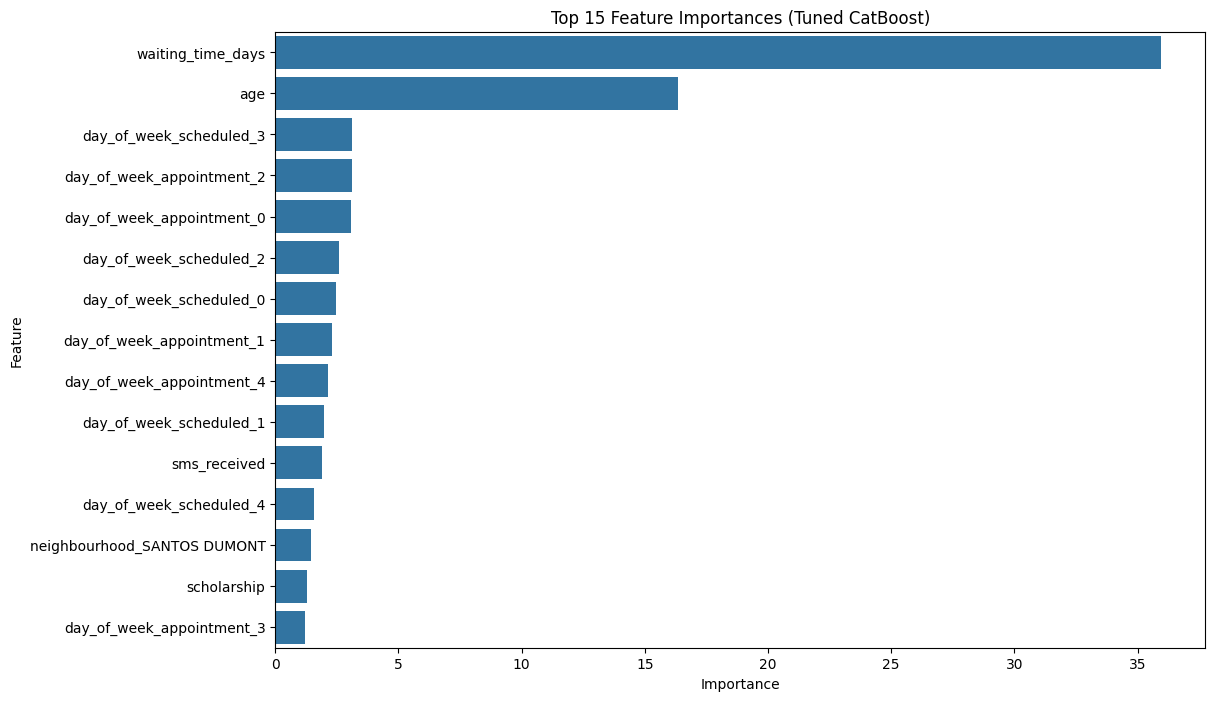

In [10]:
best_catboost_classifier = best_catboost_model.named_steps['classifier']

feature_importances = best_catboost_classifier.get_feature_importance()


ohe_feature_names = best_catboost_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)

all_feature_names = numerical_features + list(ohe_feature_names)

features_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

print("\nTop 15 Feature Importances (Tuned CatBoost):")
print(features_df.head(15))

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df.head(15))
plt.title('Top 15 Feature Importances (Tuned CatBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()